# Adhesive Simulation of the contact of a sphere

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography
from Adhesion.Interactions import PowerLaw
from Adhesion.System import BoundedSmoothContactSystem
from ContactMechanics.Tools.Logger import screen, Logger
from SurfaceTopography.Special import make_sphere
from NuMPI.IO.NetCDF import NCStructuredGrid
from Adhesion.ReferenceSolutions import JKR


Nondimensionalisation using the JKR units following the convensions in Maugis' book.
See https://contactengineering.github.io/Adhesion/source/Adhesion.ReferenceSolutions.html#module-Adhesion.ReferenceSolutions.JKR and/or https://doi.org/10.1016/j.jmps.2022.104781 , https://doi.org/10.1088/0022-3727/41/16/163001

In [2]:
R = 1
w = 1/ np.pi 
Es = 3/4

## Prepare Geometry

<ipython-input-3-6bb12aa4f1e9>:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), t.heights()), label = "heights")


Text(0, 0.5, 'y ($z_0$)')

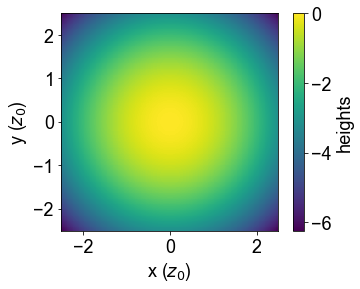

In [3]:
nx, ny = 256,256

sx = 5
sy = 5 

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2

t = make_sphere(radius=R, nb_grid_pts=(nx, ny), physical_sizes=(sx , sy), kind="paraboloid")

fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), t.heights()), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("y ($z_0$)")

Text(0, 0.5, 'heights ($z_0$)')

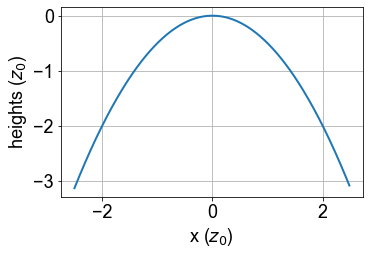

In [4]:
fig, ax = plt.subplots()
ax.plot(x, t.heights()[:, ny//2])
ax.set_aspect(1)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("heights ($z_0$)")

## Setup system

### Choosing appropriate discretization

Guideline for appropriate discretisation. 

With the exponential and the cubic interaction potential close to the JKR limit, the pixel size needs to be smaller than $2\rho^2$ (in JKR units).

$$
dx \leq 2 \rho^2 \frac{4}{3\pi} \frac{1}{\ell_a}
$$

with $\ell_a = w_{int} / E^\prime$

Note: I determined the numerical factor empirically for the exponential and the cubic potential in the dataset c83b545e-1385-47a7-adc6-ac9a24c02e39, discretisation_hysteresis_overview.html.

Several arguments lead to this scaling relation:

1. More than one pixels need to fall within the range of interaction at the edge of the contact. We estimate the gap at the contact edge using the JKR equation. 

2. The region where the stresses peak to the maximimum cohesive stress is called the cohesive zone and needs to include more than one pixel. The width of this region can be estimated from the region where the square-root singular stresses of the JKR solution exceed the max interaction stress. See e.g. [Pohrt and Popov 2015](https://eds.s.ebscohost.com/abstract?site=eds&scope=site&jrnl=03542025&AN=102396230&h=iFXqZ3C8CtweMQrf8a%2bDvdqqxAsDZsUJqlRrgcoUV9RtbO3xhCb%2be%2b8cXCY4qScc%2fzZSOR7GTlUaVs8neUuNAw%3d%3d&crl=f&resultLocal=ErrCrlNoResults&resultNs=Ehost&crlhashurl=login.aspx%3fdirect%3dtrue%26profile%3dehost%26scope%3dsite%26authtype%3dcrawler%26jrnl%3d03542025%26AN%3d102396230).

3. The elastic coupling between neighboring pixels (the stiffness associeted with the highest Fourier mode $\sim E^* / \Delta x$) should be stronger than the stiffness of the interaction force $\phi^{\prime\prime}$. This requirement means that $\min(\phi^{\prime\prime}) \sim w / \rho^2 < E^* / \Delta x$, up to a numerical prefactor. 
This argument was put forward by [Wang, Zhou and Müser 2021](https://doi.org/10.3390/lubricants9020017) (See Equation (9) and Fig.8).

4. [Persson and Scarraggi](), Appendix A: Consider a penny-shaped crack of size one pixel. In the continuum and JKR limit, a penny shaped crack propagates at a a critical stress $\sim \sqrt{w E \Delta x}$. If the interaction strength is larger than this value, the crack will grow at larger stresses than predicted by the continuum, JKR limit, leading to artificially large adhesion. 



Arguments similar to 2 and 4  lead to an implementation of adhesion using a pixel detachment criterion in Refs. [Hulikal et al. 2017](http://dx.doi.org/10.1007/s10409-016-0630-y) and [Pohrt and Popov 2015](https://eds.s.ebscohost.com/abstract?site=eds&scope=site&jrnl=03542025&AN=102396230&h=iFXqZ3C8CtweMQrf8a%2bDvdqqxAsDZsUJqlRrgcoUV9RtbO3xhCb%2be%2b8cXCY4qScc%2fzZSOR7GTlUaVs8neUuNAw%3d%3d&crl=f&resultLocal=ErrCrlNoResults&resultNs=Ehost&crlhashurl=login.aspx%3fdirect%3dtrue%26profile%3dehost%26scope%3dsite%26authtype%3dcrawler%26jrnl%3d03542025%26AN%3d102396230).






In [5]:
interaction_range = 0.1

In [6]:
t.pixel_size / interaction_range**2

array([1.953125, 1.953125])

In [7]:
# cubic interaction potential
interaction = PowerLaw(w,
                        # v that way the max stress is still w / rho
                        3 * interaction_range,
                        3)

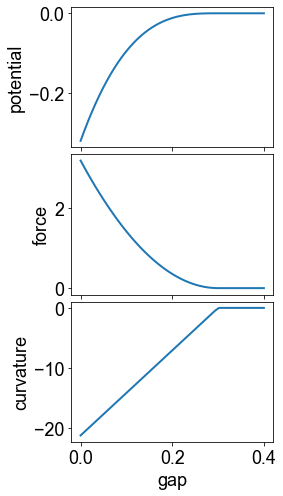

In [19]:
fig, ax = plt.subplots(3, sharex=True, figsize = (4,8))

z =np.linspace(0, 4 * interaction_range)
for poti in [interaction]:
    p,f,c = poti.evaluate(z, True, True, True)
    ax[0].plot(z,p)
    ax[1].plot(z,f)
    ax[2].plot(z,c)
    ax[0].set_ylabel("potential")
    ax[1].set_ylabel("force")
    ax[2].set_ylabel("curvature")
for a in ax:
    a.grid()
    
ax[2].set_xlabel("gap")
fig.subplots_adjust(hspace=0.05)

In [8]:
system = t.make_contact_system(
    interaction=interaction,
    system_class=BoundedSmoothContactSystem,
    young=Es
           )

#### loading history

In [9]:
def penetrations(start_pen, max_pen, dpen):
    """
    The advantage of using this function is that it generates penetrations that are exactly the same during approach and retraction. 
    
    naively incrementing like `penetration += dpen` gives slightly different values due to numerical roundoff errors.
    """
    i = 0  # integer penetration value
    pen = start_pen + dpen * i
    yield pen
    while pen < max_pen:
        i += 1
        pen = start_pen +dpen * i
        yield pen
    while True:
        i -= 1
        pen = start_pen + dpen * i
        yield pen

In [10]:
start_pen = - interaction.cutoff_radius # before the jump into contact instability
max_pen=1.5
dpen = 0.2

### Simulate

Choice of the gradient tolerance: The gradient is the error in the balance 
of the elastic-force and the adhesive force on each pixel. 

This error should be small compared to this force. 

For simulations with adhesion close to the JKR limit, the maximum stress is usually given by the interaction. 

In the DMT regime, it would be given by the contact 
 

In [11]:
gtol = 1e-4 * abs(interaction.max_tensile) * t.area_per_pt

In [12]:

# create outputfile
ncfilename="sphere_simulation_hardwall_cubic.nc"
nc = NCStructuredGrid(ncfilename, "w", nb_domain_grid_pts=t.nb_grid_pts)

disp0=None
i=0
penetration_prev = -10
i = 0
for penetration in penetrations(start_pen, max_pen, dpen):
    
    print(f"penetration = {penetration}")
    sol = system.minimize_proxy(                                       
        initial_displacements=disp0,                                                                                       
        options=dict(gtol=gtol, # max absolute value of the gradient of the objective for convergence 
                     ftol=0, # stop only if the gradient criterion is fullfilled
                     maxcor=3 # number of gradients stored for hessian approximation
                    ),                               
        logger=Logger("laststep.log"),                                 
        offset=penetration,                                           
        callback=None,                                                 
                )
    assert sol.success, sol.message
    disp0 = u = system.disp 
    
    # dumping results
    fr = nc[i]
    fr.penetration = penetration
    fr.normal_force = system.compute_normal_force()
    fr.contact_area =system.compute_contact_area()
    fr.repulsive_area = system.compute_repulsive_contact_area()
    fr.pressures = - system.substrate.evaluate_force(u)[system.substrate.topography_subdomain_slices] / system.area_per_pt
    fr.elastic_displacements = system.disp[system.surface.subdomain_slices] 
    

    if penetration < penetration_prev and fr.contact_area == 0:
        print("left contact")
        break 
    penetration_prev = penetration
    
    i+=1
nc.close()

penetration = -0.30000000000000004
penetration = -0.10000000000000003
penetration = 0.09999999999999998
penetration = 0.30000000000000004
penetration = 0.5
penetration = 0.7
penetration = 0.9000000000000001
penetration = 1.1
penetration = 1.3
penetration = 1.5
penetration = 1.3
penetration = 1.1
penetration = 0.9000000000000001
penetration = 0.7
penetration = 0.5
penetration = 0.30000000000000004
penetration = 0.09999999999999998
penetration = -0.10000000000000003
penetration = -0.30000000000000004
penetration = -0.5
penetration = -0.7000000000000001
penetration = -0.9000000000000001
penetration = -1.1
left contact


## plot pressure distributions and deformed profiles

In [13]:
nc = NCStructuredGrid(ncfilename)

<ipython-input-14-f33233a37a57>:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(axf.pcolormesh(*t.positions(), nc.pressures[i, ...]), label="pressures", ax = axf)
<ipython-input-14-f33233a37a57>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))


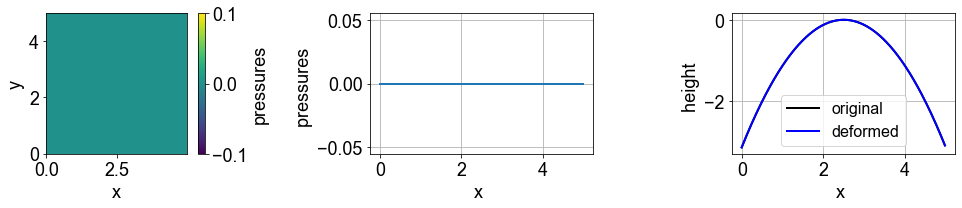

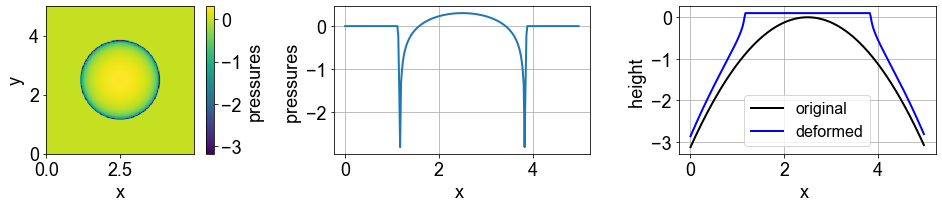

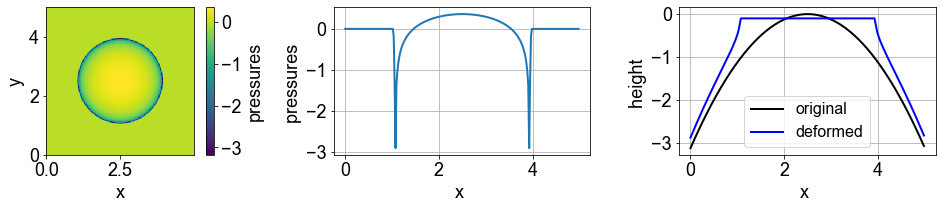

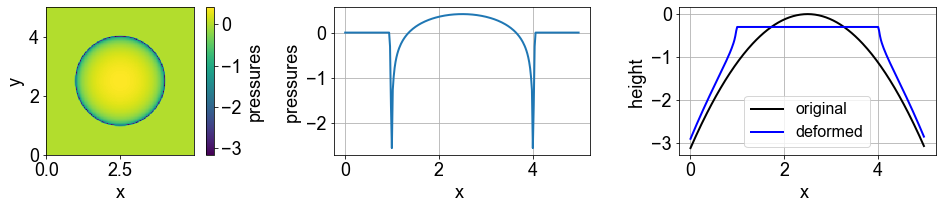

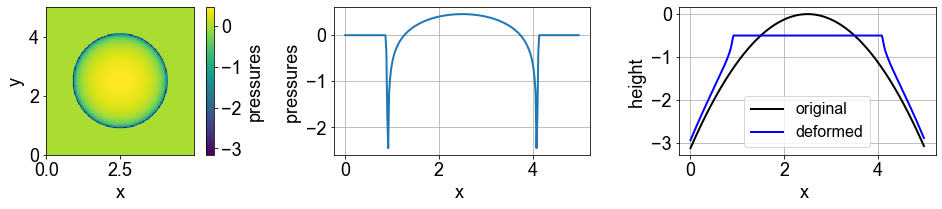

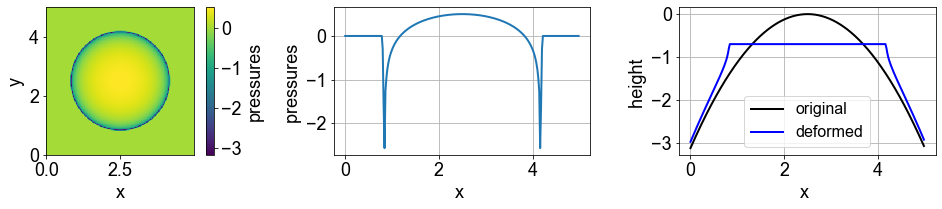

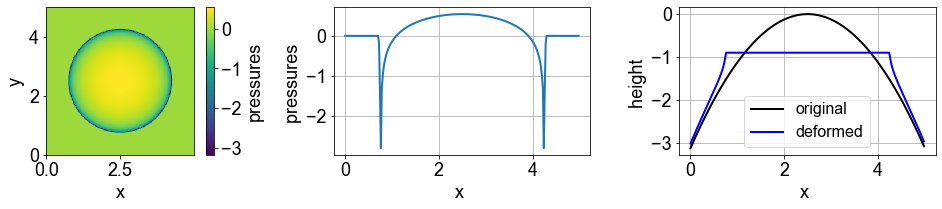

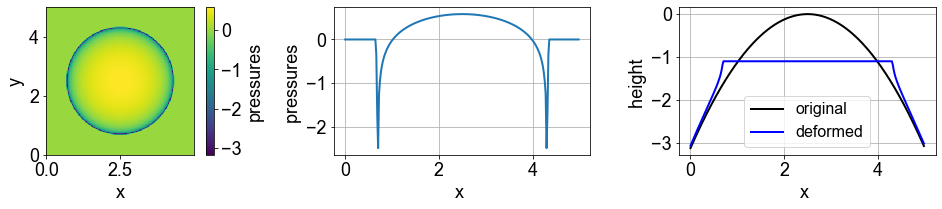

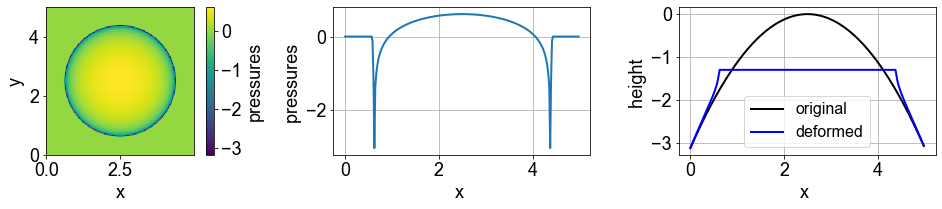

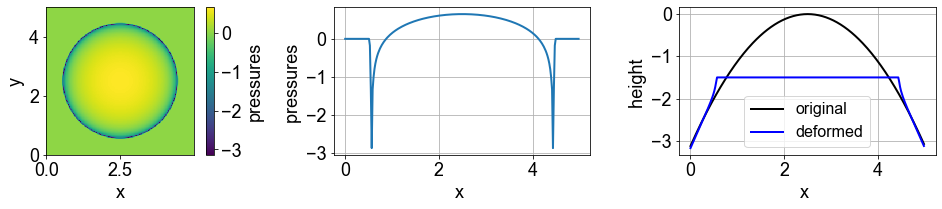

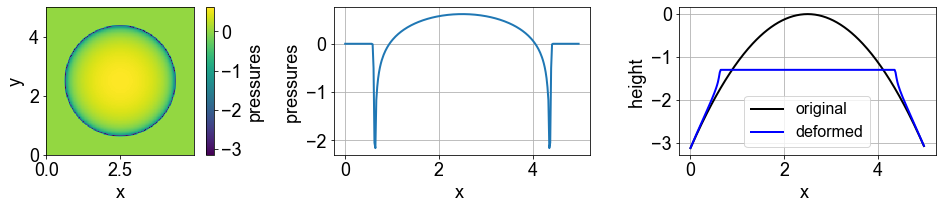

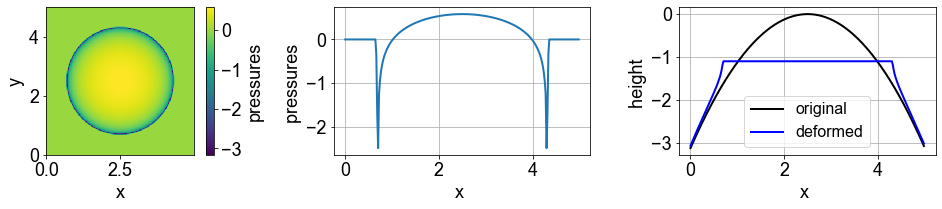

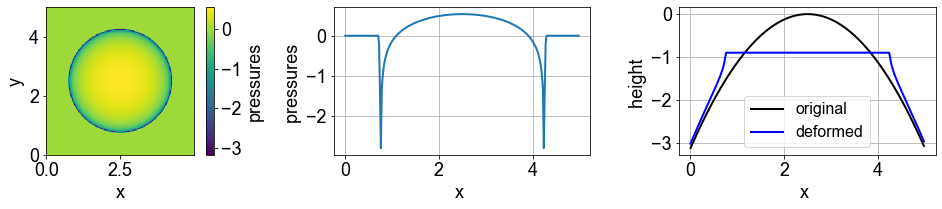

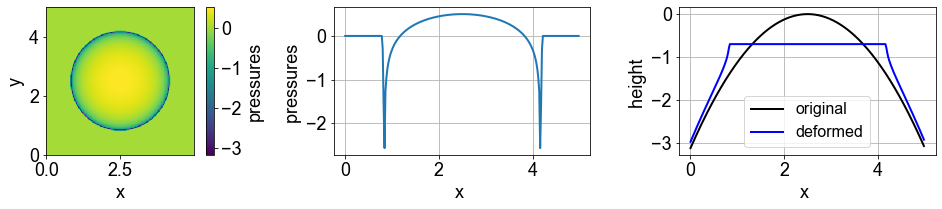

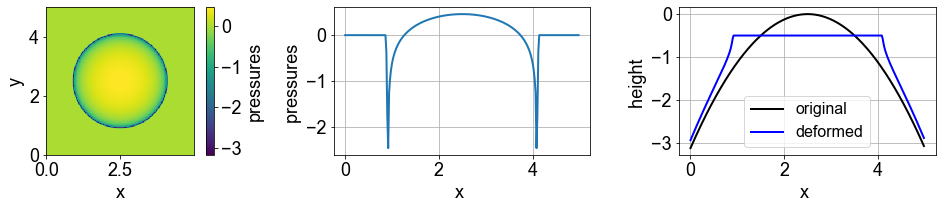

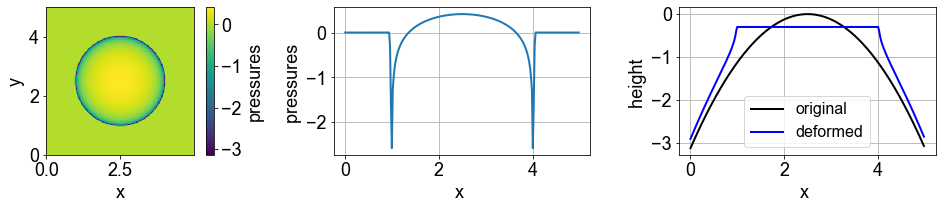

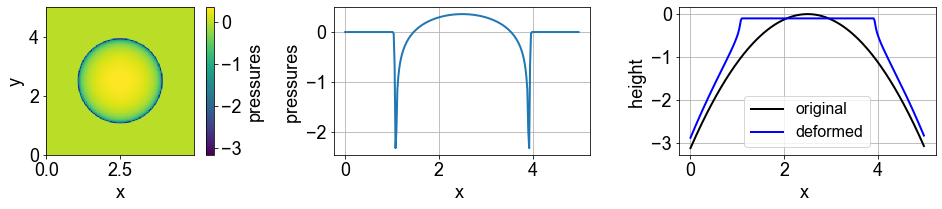

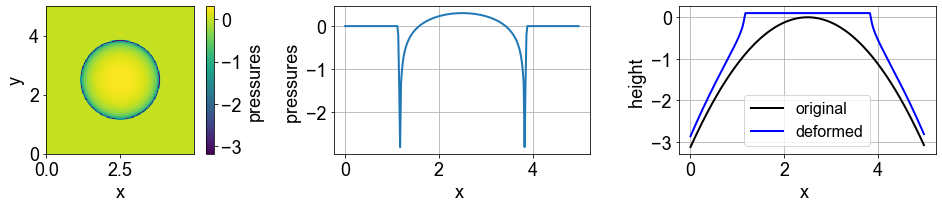

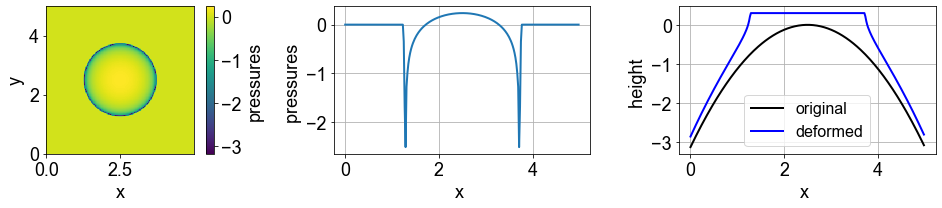

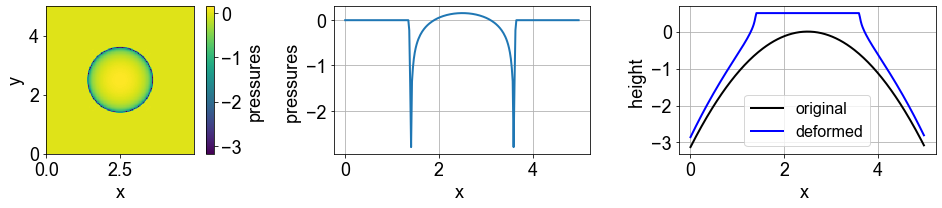

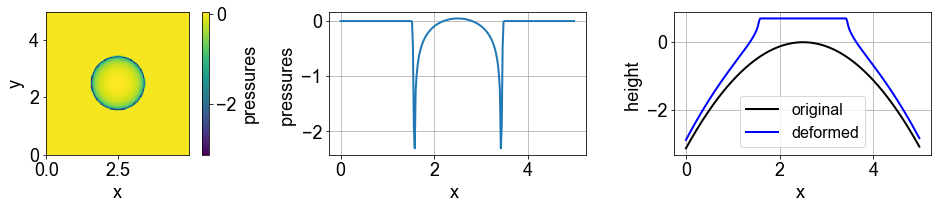

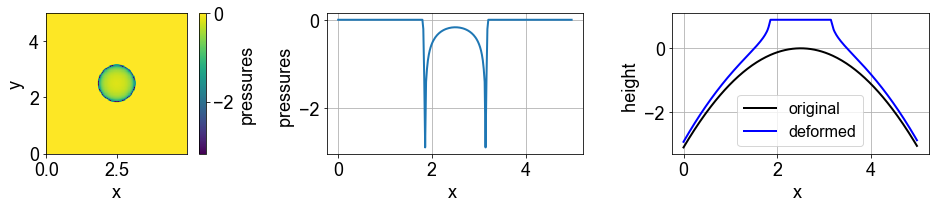

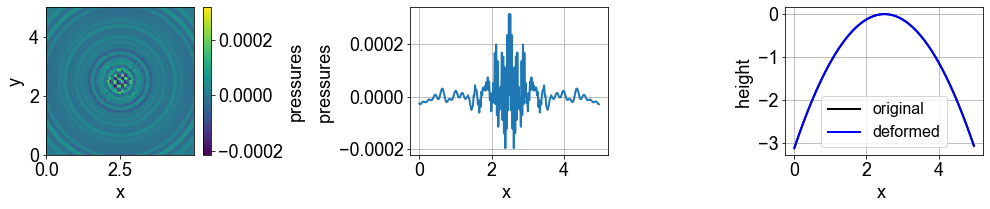

In [14]:
for i in range(len(nc)):
    
    fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))
    
    axf.set_xlabel("x")
    axf.set_ylabel("y")
        
    axfcut.plot(t.positions()[0][:,0], nc.pressures[i, :, ny//2])
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures ")
    
    for a in (axfcut, axtopcut):
        a.set_xlabel("x ")
    axtopcut.set_ylabel("height ")
    
    plt.colorbar(axf.pcolormesh(*t.positions(), nc.pressures[i, ...]), label="pressures", ax = axf)
    axf.set_aspect(1)
    
    axtopcut.plot(t.positions()[0][:,0], t.heights()[:, ny//2], 
                  color="k", label = "original")
    axtopcut.plot(t.positions()[0][:,0], t.heights()[:, ny//2] - nc.elastic_displacements[i,:, ny//2], 
                  c="b", label="deformed")
    axtopcut.legend()
    
    fig.tight_layout()

Note that the pressures you see in the last plot are the numerical errors.

## Scalar quantities during loading

Text(0, 0.5, 'Force $F^{*}$')

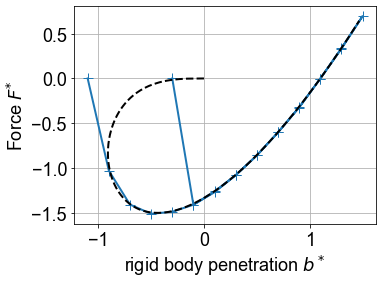

In [15]:
fig, ax = plt.subplots()

ax.plot(nc.penetration[:], nc.normal_force[:],"+-")

contact_radii = np.linspace(0,np.max(np.sqrt(nc.contact_area[:]/np.pi)),200)
ax.plot(JKR.penetration(contact_radius=contact_radii),JKR.force(contact_radius=contact_radii), "--k", label="JKR")
ax.set_xlabel("rigid body penetration $b^*$")
ax.set_ylabel("Force $F^{*}$")

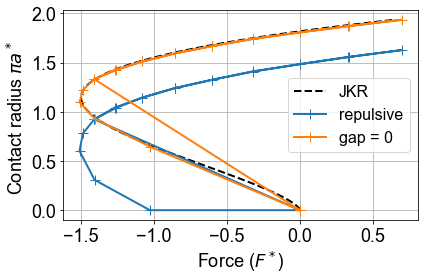

In [16]:
fig, ax = plt.subplots()

contact_radii = np.linspace(0,np.max(np.sqrt(nc.contact_area[:]/np.pi)),200)
ax.plot(JKR.force(contact_radius=contact_radii), contact_radii, "--k", label="JKR")

ax.plot(nc.normal_force[:], np.sqrt(nc.repulsive_area[:] / np.pi), "+-", label="repulsive")
ax.plot(nc.normal_force[:], np.sqrt(nc.contact_area[:] / np.pi), "+-", label="gap = 0")
ax.set_xlabel(r"Force ($F^*$)")
ax.set_ylabel(r"Contact radius $\pi a^*$ ")
fig.tight_layout()
ax.legend()

## Further experiments

Decrease tthe number of grid points to 64 (increasing the pixel size by a factor of 4). Is the result still qualitatively accurate ? 

Decreasing the interaction range will lead to similar issues (but requires more patience).